# World Cup Simulation

After watching the world cup this year in Qatar and all the wild upsets there seemed to be, I got interested in the idea of trying to model the outcomes of games in order to try to predict winners. After doing some research on the internet, I found a great [medium article](https://medium.com/latinxinai/predicting-fifa-2022-world-cup-with-machine-learning-640f1d2d7e98) by Sergio Pessoa about this subject, so I thought it'd be fun to try my own hand at this task. I ended up using some of his code to read in and clean the data as well as run simulations.

The first step in the process is to read in all the world cup results and fifa rankings into a dataframe. You can see a printout of the resulting merged dataframe below.

In [1]:
import pandas as pd
df =  pd.read_csv("../data/world_cup/results.csv") #games between national teams
df["date"] = pd.to_datetime(df["date"])
df = df[(df["date"] >= "2018-8-1")].reset_index(drop=True) #games at the 2022 wc cycle
df_wc = df #pre-wc outcomes

rank = pd.read_csv("../data/world_cup/fifa_ranking-2022-10-06.csv") #rankings
rank["rank_date"] = pd.to_datetime(rank["rank_date"]) 
rank = rank[(rank["rank_date"] >= "2018-8-1")].reset_index(drop=True) #selecting games from the 2022 wc cycle
rank["country_full"] = rank["country_full"].str.replace("IR Iran", "Iran").str.replace("Korea Republic", "South Korea").str.replace("USA", "United States") #ajustando nomes de algumas seleções
rank = rank.set_index(['rank_date']).groupby(['country_full'], group_keys=False).resample('D').first().fillna(method='ffill').reset_index()
rank_wc = rank #dataframe with rankings

#Making the merge
df_wc_ranked = df_wc.merge(rank[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date"]], left_on=["date", "home_team"], right_on=["rank_date", "country_full"]).drop(["rank_date", "country_full"], axis=1)
df_wc_ranked = df_wc_ranked.merge(rank[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date"]], left_on=["date", "away_team"], right_on=["rank_date", "country_full"], suffixes=("_home", "_away")).drop(["rank_date", "country_full"], axis=1)

In [2]:
from IPython.display import display
display(rank_wc)

,rank_date,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation
0,2018-08-16,145.0,Afghanistan,AFG,1068.00,1068.00,0.0,AFC
1,2018-08-17,145.0,Afghanistan,AFG,1068.00,1068.00,0.0,AFC
2,2018-08-18,145.0,Afghanistan,AFG,1068.00,1068.00,0.0,AFC
3,2018-08-19,145.0,Afghanistan,AFG,1068.00,1068.00,0.0,AFC
4,2018-08-20,145.0,Afghanistan,AFG,1068.00,1068.00,0.0,AFC
...,...,...,...,...,...,...,...,...
318894,2022-10-02,123.0,Zimbabwe,ZIM,1138.56,1138.56,0.0,CAF
318895,2022-10-03,123.0,Zimbabwe,ZIM,1138.56,1138.56,0.0,CAF
318896,2022-10-04,123.0,Zimbabwe,ZIM,1138.56,1138.56,0.0,CAF
318897,2022-10-05,123.0,Zimbabwe,ZIM,1138.56,1138.56,0.0,CAF


Next, I define all the functions needed to essentially simulate the outcome of a game and the associated probabilities of a loss, draw, or win. First, I calculate all the features needed for a specific team, then for each team I train a multinomial logistic regression model on a set of features since 2018. I used a multinomial logistic regression model to account for loss, draw, and win outcomes. The features used to train each model are fifa points, opponent points, team rank and opponent rank (not the most dynamic set of features I know...). Then, to simulate an outcome of two teams playing each other, I take the outputs of the models for each team and simply average them. The result is a probability for loss, draw, and win which can then be used to sample an outcome based on those probabilities.

Because of the features used, these perhaps are the most elaborate models, but it would be pretty straightforward to add more features to these models like weather for example if the effort was made to scrape that data. Another downside to this approach is that only the first knockout round allows for matches to result in draws. The later stages go to penalty kicks if needed - which is something that might be better off modeled separately because penalty kicks are a slightly different skillset than regular soccer gameplay.

In [3]:
import numpy as np
from sklearn.linear_model import LogisticRegression

def calc_team_features(df_wc_ranked, team):
    """ Calculate all features for a specific team
    """
    df_team = df_wc_ranked.copy(deep=True)
    df_team = df_team[(df_team["home_team"] == team) | (df_team["away_team"] == team)].sort_values(by="date", ascending=False)
    df_team[f"{team}_points"] = df_team.apply(lambda x: x.total_points_home if x.home_team==team else x.total_points_away,axis=1)
    df_team[f"opponent_points"] = df_team.apply(lambda x: x.total_points_home if x.home_team!=team else x.total_points_away,axis=1)
    df_team[f"{team}_goals"] = df_team.apply(lambda x: x.home_score if x.home_team==team else x.away_score,axis=1)
    df_team["opponent_goals"] = df_team.apply(lambda x: x.home_score if x.home_team!=team else x.away_score,axis=1)
    df_team[f"{team}_rank"] = df_team.apply(lambda x: x.rank_home if x.home_team==team else x.rank_away,axis=1)
    df_team["opponent_rank"] = df_team.apply(lambda x: x.rank_home if x.home_team!=team else x.rank_away,axis=1)
    df_team[f"{team}_win"] = df_team.apply(lambda x: 2 if x[f"{team}_goals"] > x.opponent_goals else 0, axis=1)
    df_team[f"{team}_win"] = df_team.apply(lambda x: 1 if x[f"{team}_goals"] == x.opponent_goals else x[f"{team}_win"], axis=1)

    return df_team

def fit_lr_from_team_df(team_df, team):
    """ Fit logistic regression model for team
    """
    X = team_df[[f"{team}_points", f"{team}_rank", "opponent_points", "opponent_rank"]]
    y = team_df[f"{team}_win"]
    clf = LogisticRegression(random_state=0, multi_class="multinomial", max_iter=1000).fit(X.values, y.values)
    return clf, X.columns

def predict_matchup_probs(team_a, team_b, df_wc_ranked):
    """ Predict matchup probabilities for pair of teams
    """
    team_a_df = calc_team_features(df_wc_ranked, team_a)
    team_b_df = calc_team_features(df_wc_ranked, team_b)
    model_a, columns_a = fit_lr_from_team_df(team_a_df, team_a)
    model_b, columns_b = fit_lr_from_team_df(team_b_df, team_b)

    team_a_features = team_a_df.sort_values(by="date").iloc[0][columns_a]
    team_b_features = team_b_df.sort_values(by="date").iloc[0][columns_b]

    team_a_features["opponent_rank"] = team_b_features[f"{team_b}_rank"]
    team_a_features["opponent_points"] = team_b_features[f"{team_b}_points"]

    team_b_features["opponent_rank"] = team_a_features[f"{team_a}_rank"]
    team_b_features["opponent_points"] = team_a_features[f"{team_a}_points"]

    team_a_predict = model_a.predict_proba(team_a_features.values.reshape(1,-1)).squeeze()
    team_b_predict = model_b.predict_proba(team_b_features.values.reshape(1,-1)).squeeze()

    # Team a lose, Team a draw, Team a win
    return np.mean([team_a_predict, team_b_predict[::-1]], axis=0)

def simulate_outcome(team_a, team_b, df_wc_ranked):
    """ Use probabilties to simulate an outcome
    """

    probs = predict_matchup_probs(team_a, team_b, df_wc_ranked)

    outcome_dict = {0: "Lose", 1: "Draw", 2: "Win"}
    outcome = np.random.choice([0,1,2], p=probs)

    return outcome_dict[outcome], probs



Here's an example simulated outcome where Germany beats Sweden where probabilities of loss, draw, and win are .108, .407, and .484 respectively.

In [4]:
simulate_outcome("Germany", "Sweden", df_wc_ranked)

('Win', array([0.10834382, 0.40716244, 0.48449374]))

Next, I can read in some data from the world cup Wikipedia page on the schedule of games to get all the matchups (thank you to Sergio for this code!).

In [5]:
dfs = pd.read_html(r"https://en.wikipedia.org/wiki/2022_FIFA_World_Cup#Teams")
matches = []
groups = ["A", "B", "C", "D", "E", "F", "G", "H"]
group_count = 0 

table = {}
table[groups[group_count]] = [[a.split(" ")[0], 0, []] for a in list(dfs[9].iloc[:, 1].values)]

for i in range(12, 67, 1):
    if len(dfs[i].columns) == 3:
        team_1 = dfs[i].columns.values[0]
        team_2 = dfs[i].columns.values[-1]
        
        matches.append((groups[group_count], team_1, team_2))
    else:
        if group_count < len(groups) - 1:
            group_count+=1
            table[groups[group_count]] = [[a, 0, []] for a in list(dfs[i].iloc[:, 1].values)]

Now, we can simulate the knockout round using the simulated outcomes!

In [6]:
from operator import itemgetter

advanced_group = []
last_group = ""
thresh = 0.05

for k in table.keys():
    for t in table[k]:
        t[1] = 0
        t[2] = []
        
for teams in matches:
    draw = False

    outcome, probs = simulate_outcome(teams[1], teams[2], df_wc_ranked)
    
    if outcome == "Draw":
        draw=True
        for i in table[teams[0]]:
            if i[0] == teams[1] or i[0] == teams[2]:
                i[1] += 1
                
    elif outcome == "Win":
        winner = teams[1]
        winner_proba = probs[2]
        for i in table[teams[0]]:
            if i[0] == teams[1]:
                i[1] += 3
                
    elif outcome == "Lose":  
        winner = teams[2]
        winner_proba = probs[0]
        for i in table[teams[0]]:
            if i[0] == teams[2]:
                i[1] += 3
    
    for i in table[teams[0]]: #adding criterio de desempate (probs por jogo)
            if i[0] == teams[1]:
                i[2].append(probs[2])
            if i[0] == teams[2]:
                i[2].append(probs[0])

    if last_group != teams[0]:
        if last_group != "":
            print("\n")
            print("Group %s advanced: "%(last_group))
            
            for i in table[last_group]: #adding crieterio de desempate
                i[2] = np.mean(i[2])
            
            final_points = table[last_group]
            final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
            advanced_group.append([final_table[0][0], final_table[1][0]])
            for i in final_table:
                print("%s -------- %d"%(i[0], i[1]))
        print("\n")
        print("-"*10+" Starting Analysis for Group %s "%(teams[0])+"-"*10)
        
        
    if draw == False:
        print(f"Group {teams[0]} - {teams[1]} vs. {teams[2]}: Winner {winner} with {probs} probs")
    else:
        print(f"Group {teams[0]} - {teams[1]} vs. {teams[2]}: Draw with {probs} probs")
    last_group =  teams[0]

print("\n")
print("Group %s advanced: "%(last_group))

for i in table[last_group]: #adding crieterio de desempate
    i[2] = np.mean(i[2])
            
final_points = table[last_group]
final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
advanced_group.append([final_table[0][0], final_table[1][0]])
for i in final_table:
    print("%s -------- %d"%(i[0], i[1]))



---------- Starting Analysis for Group A ----------
Group A - Qatar vs. Senegal: Winner Senegal with [0.60440592 0.08547593 0.31011816] probs
Group A - Netherlands vs. Ecuador: Winner Ecuador with [0.25324966 0.13839087 0.60835947] probs
Group A - Ecuador vs. Senegal: Winner Senegal with [0.62165744 0.07157989 0.30676267] probs
Group A - Netherlands vs. Qatar: Winner Qatar with [0.16330639 0.09224061 0.74445301] probs


Group A advanced: 
Senegal -------- 6
Ecuador -------- 3
Qatar -------- 3
Netherlands -------- 0


---------- Starting Analysis for Group B ----------
Group B - England vs. Iran: Winner England with [0.15437205 0.42272056 0.42290739] probs
Group B - United States vs. Wales: Draw with [0.41453589 0.21946167 0.36600244] probs
Group B - Wales vs. Iran: Winner Wales with [0.24840713 0.45304828 0.29854459] probs
Group B - England vs. United States: Draw with [0.28958825 0.15192027 0.55849148] probs
Group B - Wales vs. England: Winner England with [0.63596508 0.16804276 0.1

Now, we simulate the remaining rounds. In order to account for the fact that we can no longer have a draw, I add some logic to rerun the simulation until we don't get a draw as an outcome. This is a bit flawed because like I mentioned earlier the penalty kick scenario would probably warrant a different model than the regular gameplay models!

In [11]:
advanced = advanced_group
playoffs = {"Round of 16": [], "Quarter-Final": [], "Semi-Final": [], "Final": []}

for p in playoffs.keys():
    playoffs[p] = []

actual_round = ""
next_rounds = []

for p in playoffs.keys():
    if p == "Round of 16":
        control = []
        for a in range(0, len(advanced*2), 1):
            if a < len(advanced):
                if a % 2 == 0:
                    control.append((advanced*2)[a][0])
                else:
                    control.append((advanced*2)[a][1])
            else:
                if a % 2 == 0:
                    control.append((advanced*2)[a][1])
                else:
                    control.append((advanced*2)[a][0])

        playoffs[p] = [[control[c], control[c+1]] for c in range(0, len(control)-1, 1) if c%2 == 0]
        
        for i in range(0, len(playoffs[p]), 1):
            game = playoffs[p][i]
            
            home = game[0]
            away = game[1]
            team_1 = home
            team_2 = away

            outcome, probs = simulate_outcome(team_1, team_2, df_wc_ranked)
            while outcome == "Draw":
                outcome, probs = simulate_outcome(team_1, team_2, df_wc_ranked)

            team_1_prob = probs[0]
            team_2_prob = probs[2]

            if actual_round != p:
                print("-"*10)
                print("Starting simulation of %s"%(p))
                print("-"*10)
                print("\n")
            
            if outcome == "Lose":
                print(f"{home} vs. {away}: {away} advances with probs {probs}")
                next_rounds.append(away)
            else:
                print(f"{home} vs. {away}: {home} advances with probs {probs}")
                next_rounds.append(home)
            
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p
        
    else:
        playoffs[p] = [[next_rounds[c], next_rounds[c+1]] for c in range(0, len(next_rounds)-1, 1) if c%2 == 0]
        next_rounds = []
        for i in range(0, len(playoffs[p])):
            game = playoffs[p][i]
            home = game[0]
            away = game[1]
            team_1 = home
            team_2 = away
            outcome, probs = simulate_outcome(team_1, team_2, df_wc_ranked)
            while outcome == "Draw":
                outcome, probs = simulate_outcome(team_1, team_2, df_wc_ranked)

            team_1_prob = probs[0]
            team_2_prob = probs[2]
            
            if actual_round != p:
                print("-"*10)
                print("Starting simulation of %s"%(p))
                print("-"*10)
                print("\n")

            if outcome == "Lose":
                print(f"{home} vs. {away}: {away} advances with probs {probs}")
                next_rounds.append(away)
            else:
                print(f"{home} vs. {away}: {home} advances with probs {probs}")
                next_rounds.append(home)
            
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p
            

----------
Starting simulation of Round of 16
----------


Netherlands vs. England: England advances with probs [0.52997262 0.14980499 0.32022239]
Mexico vs. Denmark: Denmark advances with probs [0.49616581 0.12777959 0.3760546 ]
Spain vs. Canada: Spain advances with probs [0.04317178 0.03375235 0.92307587]
Brazil vs. Uruguay: Brazil advances with probs [0.2979174  0.28979272 0.41228988]
Ecuador vs. United States: United States advances with probs [0.626339   0.08100741 0.29265359]
Argentina vs. France: France advances with probs [0.68526856 0.25463583 0.06009561]
Japan vs. Croatia: Croatia advances with probs [0.41848872 0.16673972 0.41477156]
Serbia vs. Portugal: Serbia advances with probs [0.48509392 0.38840248 0.1265036 ]
----------
Starting simulation of Quarter-Final
----------


England vs. Denmark: England advances with probs [0.29666667 0.18220435 0.52112898]
Spain vs. Brazil: Spain advances with probs [0.43680619 0.17189713 0.39129669]
United States vs. France: France advance

Finally we can run 500 simulations and track the outputs of all of them.

In [8]:
# Total sim
from operator import itemgetter
from tqdm import tqdm
verbose = False
wc_winners = []

for sim in tqdm(range(500)):
    advanced_group = []
    last_group = ""
    thresh = 0.05

    for k in table.keys():
        for t in table[k]:
            t[1] = 0
            t[2] = []
        
    for teams in matches:
        draw = False

        outcome, probs = simulate_outcome(teams[1], teams[2], df_wc_ranked)
        
        if outcome == "Draw":
            draw=True
            for i in table[teams[0]]:
                if i[0] == teams[1] or i[0] == teams[2]:
                    i[1] += 1
                    
        elif outcome == "Win":
            winner = teams[1]
            winner_proba = probs[2]
            for i in table[teams[0]]:
                if i[0] == teams[1]:
                    i[1] += 3
                    
        elif outcome == "Lose":  
            winner = teams[2]
            winner_proba = probs[0]
            for i in table[teams[0]]:
                if i[0] == teams[2]:
                    i[1] += 3
        
        for i in table[teams[0]]:
                if i[0] == teams[1]:
                    i[2].append(probs[2])
                if i[0] == teams[2]:
                    i[2].append(probs[0])

        if last_group != teams[0]:
            if last_group != "":
                if verbose == True:
                    print("\n")
                    print("Group %s advanced: "%(last_group))
                
                for i in table[last_group]:
                    i[2] = np.mean(i[2])
                
                final_points = table[last_group]
                final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
                advanced_group.append([final_table[0][0], final_table[1][0]])
                for i in final_table:
                    if verbose == True:
                        print("%s -------- %d"%(i[0], i[1]))
            if verbose == True:
                print("\n")
                print("-"*10+" Starting Analysis for Group %s "%(teams[0])+"-"*10)
            
        if verbose == True:
            if draw == False:
                print("Group %s - %s vs. %s: Winner %s with %.2f probability"%(teams[0], teams[1], teams[2], winner, winner_proba))
            else:
                print("Group %s - %s vs. %s: Draw"%(teams[0], teams[1], teams[2]))
        last_group =  teams[0]

    if verbose == True:
        print("\n")
        print("Group %s advanced: "%(last_group))

    for i in table[last_group]:
        i[2] = np.mean(i[2])
                
    final_points = table[last_group]
    final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
    advanced_group.append([final_table[0][0], final_table[1][0]])
    for i in final_table:
        if verbose == True:
            print("%s -------- %d"%(i[0], i[1]))

    advanced = advanced_group
    playoffs = {"Round of 16": [], "Quarter-Final": [], "Semi-Final": [], "Final": []}

    for p in playoffs.keys():
        playoffs[p] = []

    actual_round = ""
    next_rounds = []

    for p in playoffs.keys():
        if p == "Round of 16":
            control = []
            for a in range(0, len(advanced*2), 1):
                if a < len(advanced):
                    if a % 2 == 0:
                        control.append((advanced*2)[a][0])
                    else:
                        control.append((advanced*2)[a][1])
                else:
                    if a % 2 == 0:
                        control.append((advanced*2)[a][1])
                    else:
                        control.append((advanced*2)[a][0])

            playoffs[p] = [[control[c], control[c+1]] for c in range(0, len(control)-1, 1) if c%2 == 0]
            
            for i in range(0, len(playoffs[p]), 1):
                game = playoffs[p][i]
                
                home = game[0]
                away = game[1]
                team_1 = home
                team_2 = away

                outcome, probs = simulate_outcome(team_1, team_2, df_wc_ranked)
                while outcome == "Draw":
                    outcome, probs = simulate_outcome(team_1, team_2, df_wc_ranked)

                team_1_prob = probs[0]
                team_2_prob = probs[2]

                if actual_round != p:
                    if verbose == True:
                        print("-"*10)
                        print("Starting simulation of %s"%(p))
                        print("-"*10)
                        print("\n")
                
                if outcome == "Lose":
                    if verbose == True:
                        print("%s vs. %s: %s advances with prob %.2f"%(home, away, away, team_2_prob))
                    next_rounds.append(away)
                else:
                    if verbose == True:
                        print("%s vs. %s: %s advances with prob %.2f"%(home, away, home, team_1_prob))
                    next_rounds.append(home)
                
                game.append([team_1_prob, team_2_prob])
                playoffs[p][i] = game
                actual_round = p
            
        else:
            playoffs[p] = [[next_rounds[c], next_rounds[c+1]] for c in range(0, len(next_rounds)-1, 1) if c%2 == 0]
            next_rounds = []
            for i in range(0, len(playoffs[p])):
                game = playoffs[p][i]
                home = game[0]
                away = game[1]
                team_1 = home
                team_2 = away
                outcome, probs = simulate_outcome(team_1, team_2, df_wc_ranked)
                while outcome == "Draw":
                    outcome, probs = simulate_outcome(team_1, team_2, df_wc_ranked)

                team_1_prob = probs[0]
                team_2_prob = probs[2]
                
                if actual_round != p:
                    if verbose == True:
                        print("-"*10)
                        print("Starting simulation of %s"%(p))
                        print("-"*10)
                        print("\n")

                if outcome == "Lose":
                    if verbose == True:
                        print("%s vs. %s: %s advances with prob %.2f"%(home, away, away, team_2_prob))
                    next_rounds.append(away)
                else:
                    if verbose == True:
                        print("%s vs. %s: %s advances with prob %.2f"%(home, away, home, team_1_prob))
                    next_rounds.append(home)
                
                game.append([team_1_prob, team_2_prob])
                playoffs[p][i] = game
                actual_round = p

                if (p=="Final"):
                    wc_winners.append(next_rounds[0])

100%|██████████| 500/500 [12:35<00:00,  1.51s/it]


If we now print out a histogram of all the winners we can see which teams win most often. Clearly France is quite the heavy favorite!

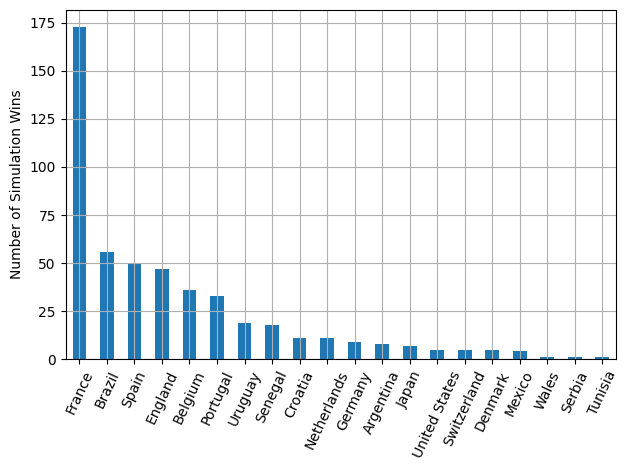

In [9]:
from matplotlib import pyplot as plt
wc_winner_df = pd.DataFrame(wc_winners, columns=["wc_winners"])
wc_winner_df["wc_winners"].value_counts().plot.bar()
plt.grid()
plt.ylabel("Number of Simulation Wins")
plt.xticks(rotation=65)
plt.tight_layout()

Lastly, we can divide by the total number of simulations to compute a probability for each team to win. France is the overwhelming favorite, and amazingly Argentina has only about a 1.6% chance to win according to this analysis! This is a pretty simplistic model and analysis but it's pretty interesting to see the results and how favored France is using these assumptions!

In [10]:
wc_winner_df.value_counts()/500

wc_winners   
France           0.346
Brazil           0.112
Spain            0.100
England          0.094
Belgium          0.072
Portugal         0.066
Uruguay          0.038
Senegal          0.036
Netherlands      0.022
Croatia          0.022
Germany          0.018
Argentina        0.016
Japan            0.014
Switzerland      0.010
United States    0.010
Denmark          0.010
Mexico           0.008
Serbia           0.002
Tunisia          0.002
Wales            0.002
dtype: float64